<a href="https://colab.research.google.com/github/Faro0oh/Week-4-Assignment/blob/main/WeeklyProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weekly Project: Image Classification with Transfer Learning

In this project, you will build a complete image classification pipeline using transfer learning. You'll work with the dataset provided by your instructor.

**Learning Objectives:**
- Load and prepare image datasets for deep learning
- Use pre-trained models for transfer learning
- Implement two transfer learning strategies: fine-tuning and feature extraction
- Evaluate model performance
- Deploy models using ONNX for production (Optional)

**References:**

- [Training with PyTorch](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Table of Contents

1. [Data Ingestion](#1)
2. [Data Preparation](#2)
3. [Model Building](#3)
4. [Training](#4)
   - [4.1 ConvNet as Fixed Feature Extractor](#4-1)
   - [4.2 Fine-tuning the ConvNet](#4-2)
5. [Evaluation](#5)
6. [Inference on Custom Images](#6)
7. [Deployment (ONNX)](#7)

## Imports

In [2]:
# YOUR CODE HERE
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'intel-image-classification' dataset.
Path to dataset files: /kaggle/input/intel-image-classification


In [3]:
!pip install dlai_grader

In [4]:
!pip install onnx onnxscript


In [40]:
!pip install onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 119.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.7 MB/s eta 0:00:00


In [5]:
import helper_utils

In [6]:
import os
os.listdir(path)


['seg_train', 'seg_pred', 'seg_test']

## Setup Device

**Note: you will need a GPU; so please run this on Colab and specify a GPU runtime (e.g., T4-GPU)**

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


<a name='1'></a>
## 1. Data Ingestion

**Task**: The dataset should be downloaded and extracted to a local directory.

**References:**

- [Dataset and DataLoader](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#dataset-and-dataloader)
- [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

In [8]:
# YOUR CODE HERE
train_dir = os.path.join(path, "seg_train", "seg_train")
val_dir   = os.path.join(path, "seg_test", "seg_test")


**Task**: create a `train_dataset` and `test_dataset` (without transforms for now).

In [9]:
# YOUR CODE HERE
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=None)
val_dataset   = torchvision.datasets.ImageFolder(val_dir, transform=None)

**Quick Check**: verify the counts of both train and test sets, match what's in the original source (Kaggle).

In [10]:
# YOUR CODE HERE
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}
print ("the count of training set is: ", len(train_dataset))
print ("the count of test set is: " ,len(val_dataset))

the count of training set is:  14034
the count of test set is:  3000


<a name='2'></a>
## 2. Data Preparation

Before training, we need to:
1. Define augmentation for training
2. Define normalization for both training and testing
3. Create **`DataLoader`** for efficient batch processing

**Task:** Create transformation pipelines for training and validation. Pre-trained models expect ImageNet normalization statistics.

**Reference:**

- [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [12]:
# YOUR CODE HERE
from torch.utils.data import DataLoader

training_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
dataloaders = {
    "train": training_loader,
    "val": validation_loader
}

In [13]:
# YOUR CODE HERE
train_dataset.transform = data_transforms['train']
val_dataset.transform = data_transforms['val']

**Quick Check**: Visualize a batch of training images

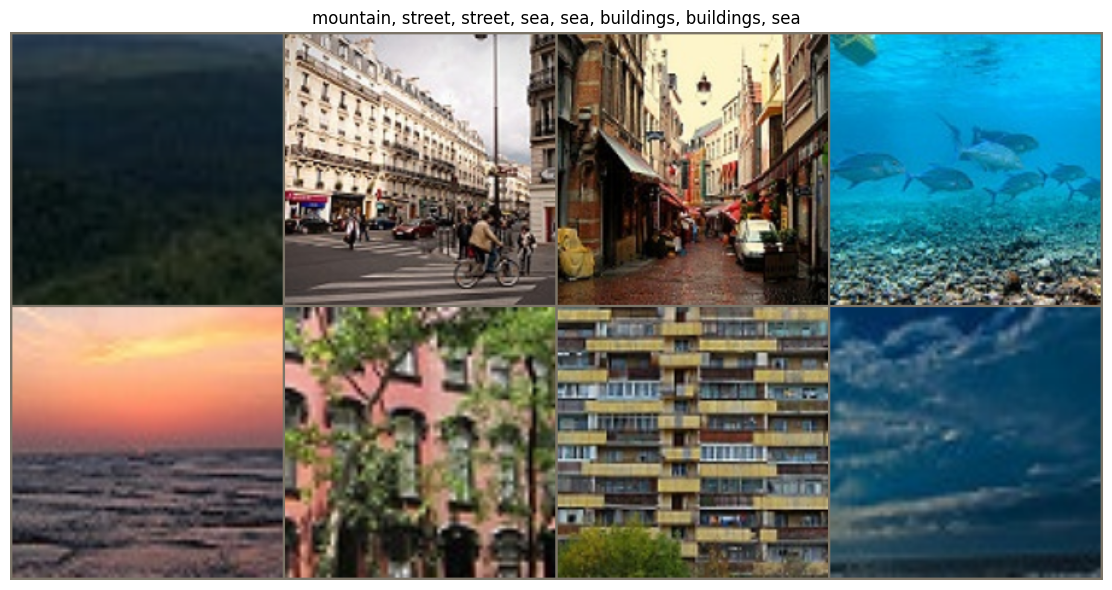

In [14]:
class_names = train_dataset.classes
helper_utils.visualize_batch(training_loader,class_names )
plt.show()

In [15]:
# YOUR CODE HERE

<a name='3'></a>
## 3. Model Building

We'll use a pre-trained ResNet-18 model and adapt it for our 6-class classification task.

**Task:** Load a pre-trained ResNet-18 model and modify the final layer for 6 classes.

**Reference:**

- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [torchvision.models](https://pytorch.org/vision/stable/models.html)
- [ResNet documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html)

In [16]:
# YOUR CODE HERE
model = models.resnet18(weights='IMAGENET1K_V1')

num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 6)

model= model.to(device)


<a name='4'></a>
## 4. Training

**Task:** Implement a training **function** and then train using two different transfer learning strategies.

**Reference:** [PyTorch Training Tutorial](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop)

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
    }


    save_dir = "./saved_models"
    os.makedirs(save_dir, exist_ok=True)
    best_model_params_path = os.path.join(save_dir, "best_model_params.pt")
    best_acc = 0.0

    for epoch in range(num_epochs):
          print(f'Epoch {epoch+1}/{num_epochs}')
          print('-' * 10)

          for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == "train":
                    history["train_loss"].append(epoch_loss)
                    history["train_acc"].append(epoch_acc.item())
                else:
                    history["val_loss"].append(epoch_loss)
                    history["val_acc"].append(epoch_acc.item())


                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)


    print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(torch.load(best_model_params_path))

    return model , history



<a name='4-1'></a>
### 4.1 ConvNet as Fixed Feature Extractor

In this approach, we freeze all the convolutional layers and only train the final classifier layer.

**Task:**

1. Load a fresh pre-trained model
2. Freeze all parameters except the final layer
3. Set up optimizer to only train the final layer
4. Train the model

In [18]:
#freeze layers
for param in model.parameters():
    param.requires_grad = False


for param in model.fc.parameters():
    param.requires_grad = True

#lose
criterion = nn.CrossEntropyLoss()

#optmizer
optimizer_ft = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#train
model_ft , history_conv = train_model(
    model,
    criterion,
    optimizer_ft,
    scheduler,
    num_epochs=10
)


Epoch 1/10
----------
train Loss: 0.6301 Acc: 0.7815
val Loss: 0.3779 Acc: 0.8853
Epoch 2/10
----------
train Loss: 0.5684 Acc: 0.8178
val Loss: 0.3929 Acc: 0.8693
Epoch 3/10
----------
train Loss: 0.5577 Acc: 0.8230
val Loss: 0.3843 Acc: 0.8763
Epoch 4/10
----------
train Loss: 0.5579 Acc: 0.8227
val Loss: 0.3046 Acc: 0.8987
Epoch 5/10
----------
train Loss: 0.5414 Acc: 0.8210
val Loss: 0.3986 Acc: 0.8823
Epoch 6/10
----------
train Loss: 0.5364 Acc: 0.8260
val Loss: 0.4246 Acc: 0.8667
Epoch 7/10
----------
train Loss: 0.5481 Acc: 0.8238
val Loss: 0.3283 Acc: 0.8947
Epoch 8/10
----------
train Loss: 0.4262 Acc: 0.8494
val Loss: 0.2704 Acc: 0.9087
Epoch 9/10
----------
train Loss: 0.4141 Acc: 0.8514
val Loss: 0.2678 Acc: 0.9120
Epoch 10/10
----------
train Loss: 0.3903 Acc: 0.8588
val Loss: 0.2593 Acc: 0.9113

Training complete in 11m 36s
Best val Acc: 0.9120


In [19]:
# YOUR CODE HERE

In [20]:
# YOUR CODE HERE

In [21]:
# YOUR CODE HERE

In [22]:
# YOUR CODE HERE

**Quick Check**: Visualize training history

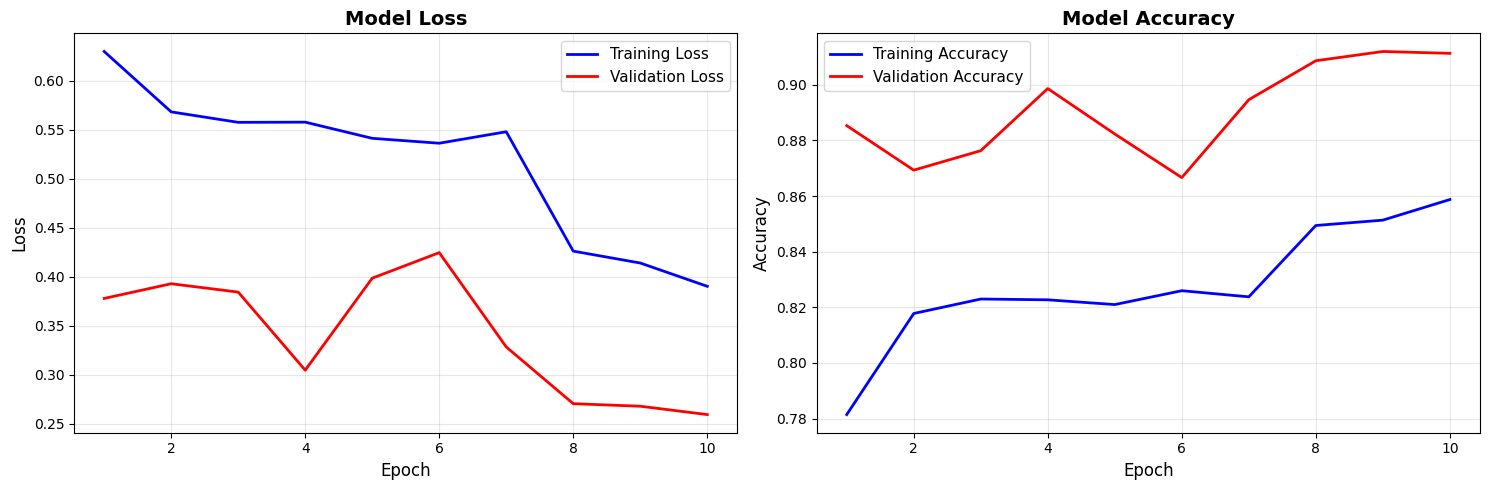

In [23]:
helper_utils.visualize_training_history(history_conv)
plt.show()

**Quick Check**: Visualize predictions

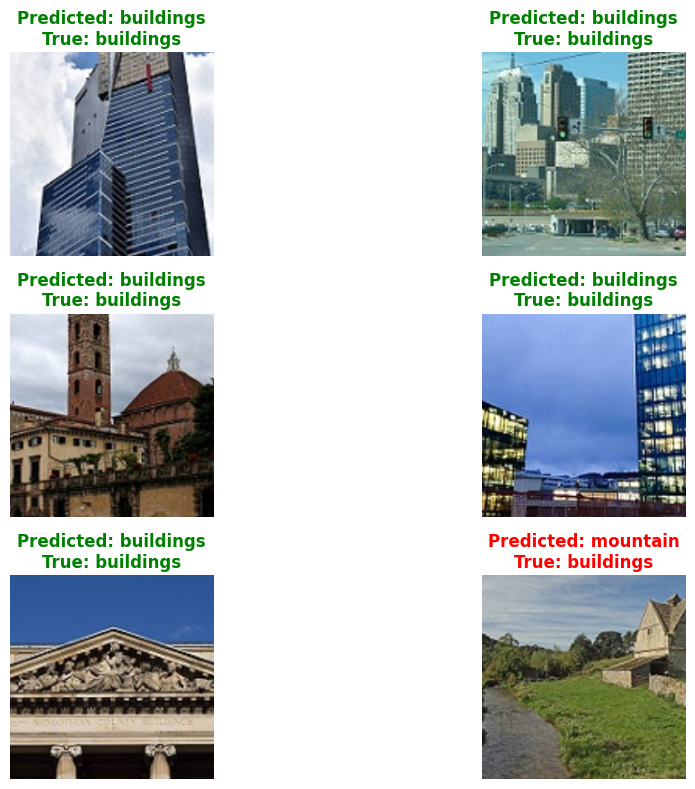

In [24]:
helper_utils.visualize_predictions(model, dataloaders['val'], class_names, device, num_images=6)
plt.show()

<a name='4-2'></a>
### 4.2 Fine-tuning the ConvNet

In this approach, we unfreeze all layers and train the entire network with a smaller learning rate.

**Task:**

1. Load a fresh pre-trained model
2. Modify the final layer
3. Set up optimizer for all parameters with a smaller learning rate
4. Train the model

In [25]:
# YOUR CODE HERE
for param in model.fc.parameters():
    param.requires_grad = True

#lose
criterion = nn.CrossEntropyLoss()

#optmizer
optimizer_ft = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#train
model_ft , history_ft = train_model(
    model,
    criterion,
    optimizer_ft,
    scheduler,
    num_epochs=10
)

Epoch 1/10
----------
train Loss: 0.5189 Acc: 0.8252
val Loss: 0.3058 Acc: 0.8993
Epoch 2/10
----------
train Loss: 0.5367 Acc: 0.8268
val Loss: 0.3493 Acc: 0.8937
Epoch 3/10
----------
train Loss: 0.5599 Acc: 0.8206
val Loss: 0.4052 Acc: 0.8740
Epoch 4/10
----------
train Loss: 0.5507 Acc: 0.8266
val Loss: 0.4133 Acc: 0.8733
Epoch 5/10
----------
train Loss: 0.5060 Acc: 0.8338
val Loss: 0.3250 Acc: 0.8947
Epoch 6/10
----------
train Loss: 0.5465 Acc: 0.8243
val Loss: 0.3372 Acc: 0.8987
Epoch 7/10
----------
train Loss: 0.5460 Acc: 0.8236
val Loss: 0.3457 Acc: 0.8980
Epoch 8/10
----------
train Loss: 0.4196 Acc: 0.8572
val Loss: 0.2766 Acc: 0.9157
Epoch 9/10
----------
train Loss: 0.4080 Acc: 0.8557
val Loss: 0.2699 Acc: 0.9090
Epoch 10/10
----------
train Loss: 0.4052 Acc: 0.8563
val Loss: 0.2673 Acc: 0.9093

Training complete in 11m 33s
Best val Acc: 0.9157


In [26]:
# YOUR CODE HERE

In [27]:
# YOUR CODE HERE

In [28]:
# YOUR CODE HERE

**Quick Check**: Visualize training history

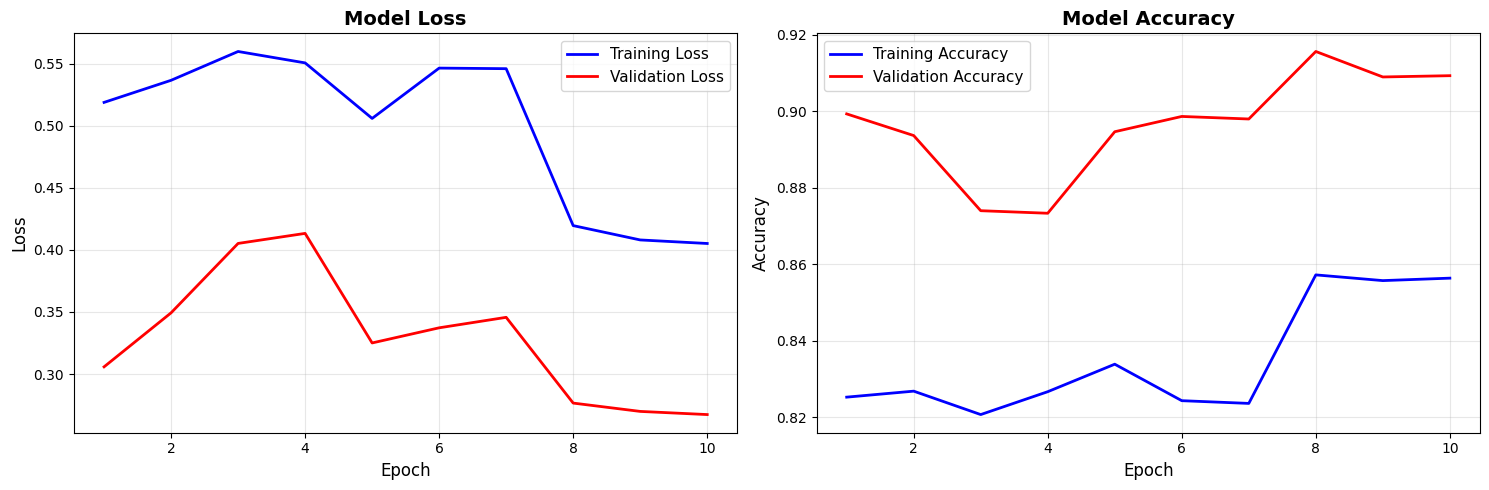

In [29]:
helper_utils.visualize_training_history(history_ft)
plt.show()

**Quick Check**: Visualize predictions

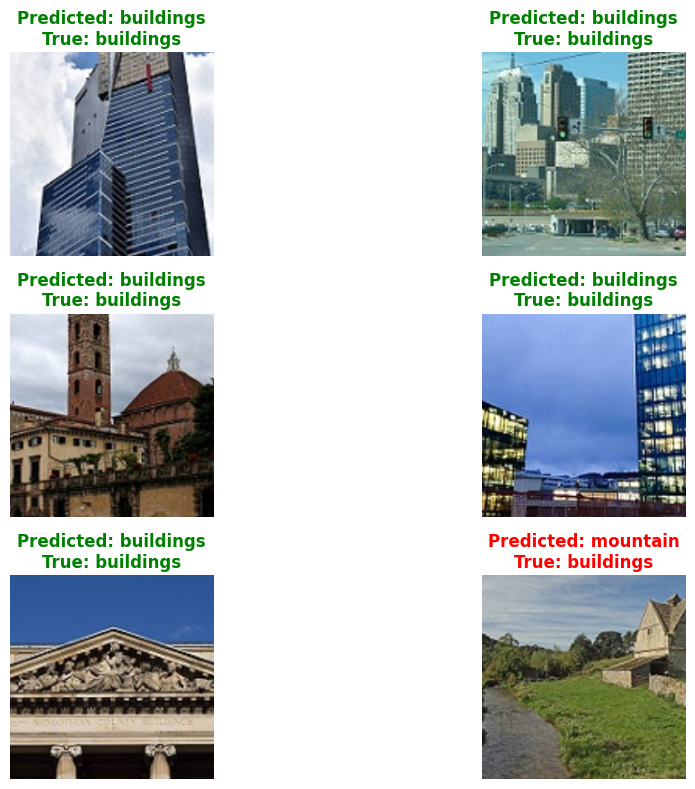

In [30]:
helper_utils.visualize_predictions(model_ft, dataloaders['val'], class_names, device, num_images=6)
plt.show()

<a name='5'></a>
## 5. Evaluation

Compare the performance of both approaches.

**Task:** Evaluate both models and compare their performance metrics.

In [31]:
# Evaluate models on validation set
# YOUR CODE HERE
# Compare final validation accuracies, training times, etc.

# Print comparison
print("Feature Extractor Approach:")
print(f"  Best Val Accuracy: {max(history_conv['val_acc']):.4f}")
print(f"  Final Val Accuracy: {history_conv['val_acc'][-1]:.4f}")
print()
print("Fine-tuning Approach:")
print(f"  Best Val Accuracy: {max(history_ft['val_acc']):.4f}")
print(f"  Final Val Accuracy: {history_ft['val_acc'][-1]:.4f}")

Feature Extractor Approach:
  Best Val Accuracy: 0.9120
  Final Val Accuracy: 0.9113

Fine-tuning Approach:
  Best Val Accuracy: 0.9157
  Final Val Accuracy: 0.9093


<a name='6'></a>
## 6. Inference on Custom Images

Test your trained model on custom images.

**Task:** Load a custom image, preprocess it, and make a prediction using your trained model.

**Reference:** [Image Preprocessing](https://pytorch.org/vision/stable/transforms.html)

Selected image: /kaggle/input/intel-image-classification/seg_test/seg_test/street/20417.jpg


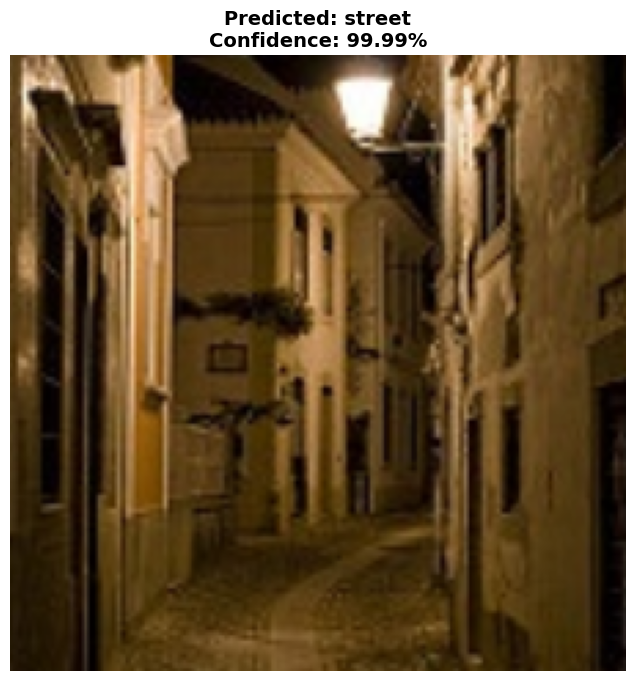

In [38]:
# Make prediction on a custom image

class_name = random.choice(os.listdir(val_dir))

img_name = random.choice(os.listdir(os.path.join(val_dir, class_name)))


img_path = os.path.join(val_dir, class_name, img_name)

print("Selected image:", img_path)


# Use helper_utils.visualize_single_prediction or helper_utils.predict_single_image
helper_utils.visualize_single_prediction(
     model_ft,  # or model_conv
     img_path,
     data_transforms['val'],
     class_names,
     device
 )
plt.show()

# 🏆🎉 Congratulations on completing the Weekly Final Project! 🎉🏆

Fantastic job on finishing the Weekly Final Project! You’ve put your skills to the test and made it to the end. Take a moment to celebrate your hard work and dedication. Keep up the great work and continue your learning journey!

<a name='7'></a>
## 7. Deployment (ONNX)

Convert your trained model to ONNX format for deployment.

**Task:**
1. Convert the PyTorch model to ONNX format
2. Load the ONNX model and perform inference

**Reference:**
- [PyTorch to ONNX](https://docs.pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html)

In [34]:
 #Convert model to ONNX
# YOUR CODE HERE
#Set model to evaluation mode
model.eval()

#Create dummy input (batch_size=1, channels=3, height=224, width=224)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

#Export to ONNX
onnx_path = 'model.onnx'
torch.onnx.export(
     model,
     dummy_input,
     onnx_path,
     input_names=['input'],
    output_names=['output'],
     dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
 )

print(f"Model exported to {onnx_path}")

/tmp/ipython-input-608354185.py:11: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 41 of general pattern rewrite rules.
Model exported to model.onnx


In [45]:


print("val_dir =", val_dir)
print("Classes in val_dir:", os.listdir(val_dir))

class_name = random.choice(os.listdir(val_dir))
img_name = random.choice(os.listdir(os.path.join(val_dir, class_name)))
img_path = os.path.join(val_dir, class_name, img_name)

print("Selected image path:", img_path)


val_dir = /kaggle/input/intel-image-classification/seg_test/seg_test
Classes in val_dir: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
Selected image path: /kaggle/input/intel-image-classification/seg_test/seg_test/glacier/23257.jpg


In [46]:
# Load ONNX model and perform inference
# YOUR CODE HERE
import onnxruntime as ort
import numpy as np
from PIL import Image

# Load ONNX model
ort_session = ort.InferenceSession(onnx_path)

# Load real image
img = Image.open(img_path).convert('RGB')
img_tensor = data_transforms['val'](img).unsqueeze(0)
img_numpy = img_tensor.numpy()

# Run inference
outputs = ort_session.run(None, {'input': img_numpy})
predictions = np.array(outputs[0])

pred_class_idx = np.argmax(predictions[0])
pred_class = class_names[pred_class_idx]
confidence = np.max(predictions[0])

print(f"Predicted: {pred_class} (confidence: {confidence:.2%})")


Predicted: glacier (confidence: 838.65%)
